In [2]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

/Users/carloskim/ml/venv/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [3]:
df = pd.read_csv("Coded_Segments.csv")
print(df.head())

               Dokumentname         Code  Anfang  Ende  \
0  reflection_assignment_P1      Level 1       1     1   
1  reflection_assignment_P1      Level 1       1     1   
2  reflection_assignment_P1      Level 1       1     1   
3  reflection_assignment_P1  Level 2 (a)       1     1   
4  reflection_assignment_P1  Level 2 (a)       1     1   

                                             Segment  
0  I am a newbie in data science (DS). On the one...  
1  However, the handling of data in basic cogniti...  
2  The HCDS course was largely aimed at a critica...  
3  Among these topics, some messages particularly...  
4  First of all, I became aware of the importance...  


In [4]:
df['Code'].value_counts()

Code
Level 3        90
Level 1        69
Level 2 (b)    41
Level 2 (a)    31
Level 4         6
Name: count, dtype: int64

(array([69.,  0., 31.,  0.,  0., 41.,  0., 90.,  0.,  6.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

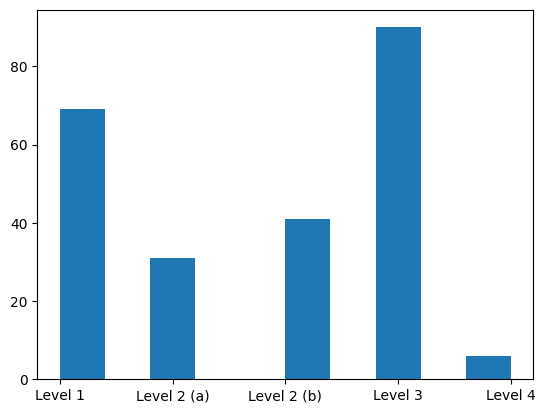

In [5]:
plt.hist(sorted(df['Code']))

In [6]:
# df['Code'].astype('category').cat.codes

In [7]:
# df['class'] = df['Code'].astype('category').cat.codes
# num_classes = df['class'].nunique()
# num_classes

In [8]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    le = LabelEncoder()
    df['class'] = le.fit_transform(df['Code'])

    # handle imbalanced dataset
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(df[['Segment']], df['class'])
    df_resampled = pd.DataFrame({'Segment': X_resampled['Segment'], 'class': y_resampled})

    print(f"Original dataset shape: {df.shape}")
    print(f"Resampled dataset shape: {df_resampled.shape}")

    return df_resampled, le

In [9]:
df_resampled, label_encoder = preprocess_data(df)
print(df_resampled)

Original dataset shape: (237, 6)
Resampled dataset shape: (450, 2)
                                               Segment  class
0    I am a newbie in data science (DS). On the one...      0
1    However, the handling of data in basic cogniti...      0
2    The HCDS course was largely aimed at a critica...      0
3    Among these topics, some messages particularly...      1
4    First of all, I became aware of the importance...      1
..                                                 ...    ...
445  The first concern, to begin  with, is to check...      4
446  The first concern, to begin  with, is to check...      4
447  Social nuances have shown how important it is ...      4
448  It also made me realise the high personal resp...      4
449  As an when my experience grew, I started to un...      4

[450 rows x 2 columns]


In [10]:
df_resampled['class'].value_counts()

class
0    90
1    90
4    90
2    90
3    90
Name: count, dtype: int64

(array([90.,  0., 90.,  0.,  0., 90.,  0., 90.,  0., 90.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

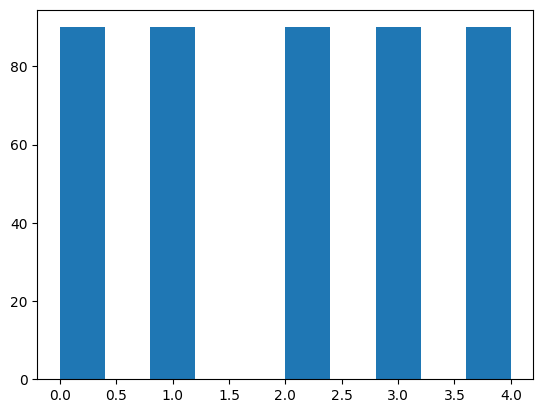

In [11]:
plt.hist(sorted(df_resampled['class']))

Validation Set Results:
Accuracy: 0.78
Cohen's Kappa: 0.72
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        13
           1       0.87      0.93      0.90        14
           2       0.65      0.85      0.73        13
           3       0.60      0.46      0.52        13
           4       1.00      1.00      1.00        14

    accuracy                           0.78        67
   macro avg       0.77      0.77      0.76        67
weighted avg       0.77      0.78      0.77        67



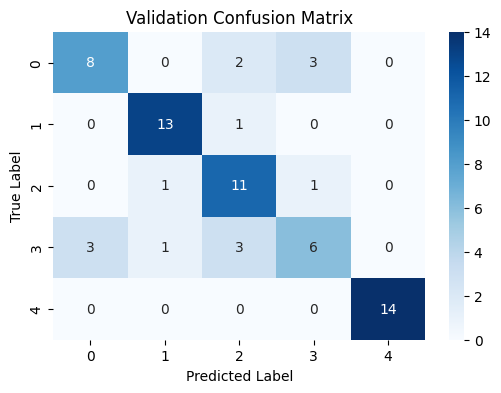


Test Set Results:
Accuracy: 0.87
Cohen's Kappa: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.81        14
           1       0.86      0.92      0.89        13
           2       0.82      1.00      0.90        14
           3       0.82      0.64      0.72        14
           4       1.00      1.00      1.00        13

    accuracy                           0.87        68
   macro avg       0.87      0.87      0.87        68
weighted avg       0.87      0.87      0.86        68



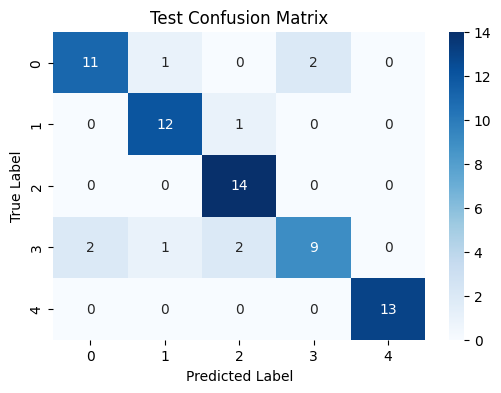

In [12]:
# Preprocessing
# Split into training, validation and test sets
train_df, temp_df = train_test_split(df_resampled, test_size=0.3, stratify=df_resampled['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

# Extract text and labels
X_train, y_train = train_df['Segment'], train_df['class']
X_val, y_val = val_df['Segment'], val_df['class']
X_test, y_test = test_df['Segment'], test_df['class']

# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Train the Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Evaluate on validation and test sets
nb_y_val_pred = nb_model.predict(X_val_tfidf)
nb_y_test_pred = nb_model.predict(X_test_tfidf)

# Metrics for validation set
nb_val_accuracy = accuracy_score(y_val, nb_y_val_pred)
nb_val_class_report = classification_report(y_val, nb_y_val_pred, zero_division=0)
nb_val_cohen_kappa = cohen_kappa_score(y_val, nb_y_val_pred)
nb_val_cm = confusion_matrix(y_val, nb_y_val_pred)

# Metrics for test set
nb_test_accuracy = accuracy_score(y_test, nb_y_test_pred)
nb_test_class_report = classification_report(y_test, nb_y_test_pred, zero_division=0)
nb_test_cohen_kappa = cohen_kappa_score(y_test, nb_y_test_pred)
nb_test_cm = confusion_matrix(y_test, nb_y_test_pred)

# Print results
print("Validation Set Results:")
print(f"Accuracy: {nb_val_accuracy:.2f}")
print(f"Cohen's Kappa: {nb_val_cohen_kappa:.2f}")
print("Classification Report:")
print(nb_val_class_report)
plt.figure(figsize=(6,4))
sns.heatmap(nb_val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_val)), yticklabels=sorted(set(y_val)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix")
plt.show()

print("\nTest Set Results:")
print(f"Accuracy: {nb_test_accuracy:.2f}")
print(f"Cohen's Kappa: {nb_test_cohen_kappa:.2f}")
print("Classification Report:")
print(nb_test_class_report)
plt.figure(figsize=(6,4))
sns.heatmap(nb_test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Confusion Matrix")
plt.show()

Validation Set Results:
Accuracy: 0.79
Cohen's Kappa: 0.74
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        13
           1       0.93      0.93      0.93        14
           2       0.69      0.85      0.76        13
           3       0.58      0.54      0.56        13
           4       1.00      1.00      1.00        14

    accuracy                           0.79        67
   macro avg       0.79      0.79      0.78        67
weighted avg       0.79      0.79      0.79        67



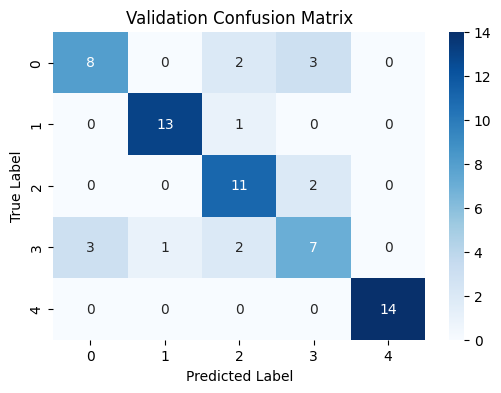


Test Set Results:
Accuracy: 0.90
Cohen's Kappa: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        14
           1       1.00      0.92      0.96        13
           2       1.00      0.93      0.96        14
           3       0.73      0.79      0.76        14
           4       1.00      1.00      1.00        13

    accuracy                           0.90        68
   macro avg       0.91      0.90      0.90        68
weighted avg       0.90      0.90      0.90        68



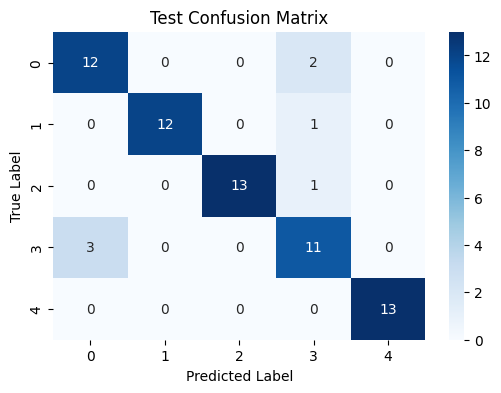

In [13]:
# Train a Logistic Regression classifier
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_tfidf, y_train)

# Evaluate on validation and test sets
lr_y_val_pred = logreg_model.predict(X_val_tfidf)
lr_y_test_pred = logreg_model.predict(X_test_tfidf)

# Metrics for validation set
lr_val_accuracy = accuracy_score(y_val, lr_y_val_pred)
lr_val_class_report = classification_report(y_val, lr_y_val_pred, zero_division=0)
lr_val_cohen_kappa = cohen_kappa_score(y_val, lr_y_val_pred)
lr_val_cm = confusion_matrix(y_val, lr_y_val_pred)

# Metrics for test set
lr_test_accuracy = accuracy_score(y_test, lr_y_test_pred)
lr_test_class_report = classification_report(y_test, lr_y_test_pred, zero_division=0)
lr_test_cohen_kappa = cohen_kappa_score(y_test, lr_y_test_pred)
lr_test_cm = confusion_matrix(y_test, lr_y_test_pred)

# Print results
print("Validation Set Results:")
print(f"Accuracy: {lr_val_accuracy:.2f}")
print(f"Cohen's Kappa: {lr_val_cohen_kappa:.2f}")
print("Classification Report:")
print(lr_val_class_report)
plt.figure(figsize=(6,4))
sns.heatmap(lr_val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_val)), yticklabels=sorted(set(y_val)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix")
plt.show()

print("\nTest Set Results:")
print(f"Accuracy: {lr_test_accuracy:.2f}")
print(f"Cohen's Kappa: {lr_test_cohen_kappa:.2f}")
print("Classification Report:")
print(lr_test_class_report)
plt.figure(figsize=(6,4))
sns.heatmap(lr_test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Confusion Matrix")
plt.show()

Validation Set Results:
Accuracy: 0.81
Cohen's Kappa: 0.76
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.62      0.64        13
           1       1.00      0.93      0.96        14
           2       0.79      0.85      0.81        13
           3       0.57      0.62      0.59        13
           4       1.00      1.00      1.00        14

    accuracy                           0.81        67
   macro avg       0.80      0.80      0.80        67
weighted avg       0.81      0.81      0.81        67



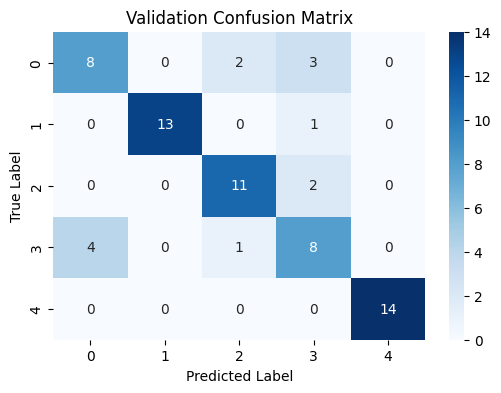


Test Set Results:
Accuracy: 0.87
Cohen's Kappa: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        14
           1       0.92      0.85      0.88        13
           2       1.00      0.93      0.96        14
           3       0.71      0.71      0.71        14
           4       1.00      1.00      1.00        13

    accuracy                           0.87        68
   macro avg       0.88      0.87      0.87        68
weighted avg       0.87      0.87      0.87        68



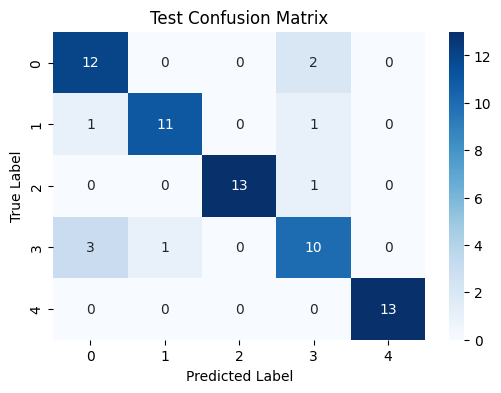

In [13]:
# Train an SVM classifier
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_tfidf, y_train)

# Evaluate on validation and test sets
svm_y_val_pred = svm_model.predict(X_val_tfidf)
svm_y_test_pred = svm_model.predict(X_test_tfidf)

# Metrics for validation set
svm_val_accuracy = accuracy_score(y_val, svm_y_val_pred)
svm_val_class_report = classification_report(y_val, svm_y_val_pred, zero_division=0)
svm_val_cohen_kappa = cohen_kappa_score(y_val, svm_y_val_pred)
svm_val_cm = confusion_matrix(y_val, svm_y_val_pred)

# Metrics for test set
svm_test_accuracy = accuracy_score(y_test, svm_y_test_pred)
svm_test_class_report = classification_report(y_test, svm_y_test_pred, zero_division=0)
svm_test_cohen_kappa = cohen_kappa_score(y_test, svm_y_test_pred)
svm_test_cm = confusion_matrix(y_test, svm_y_test_pred)

# Print results
print("Validation Set Results:")
print(f"Accuracy: {svm_val_accuracy:.2f}")
print(f"Cohen's Kappa: {svm_val_cohen_kappa:.2f}")
print("Classification Report:")
print(svm_val_class_report)
plt.figure(figsize=(6,4))
sns.heatmap(svm_val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_val)), yticklabels=sorted(set(y_val)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix")
plt.show()

print("\nTest Set Results:")
print(f"Accuracy: {svm_test_accuracy:.2f}")
print(f"Cohen's Kappa: {svm_test_cohen_kappa:.2f}")
print("Classification Report:")
print(svm_test_class_report)
plt.figure(figsize=(6,4))
sns.heatmap(svm_test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Confusion Matrix")
plt.show()

Validation Set Results:
Accuracy: 0.81
Cohen's Kappa: 0.76
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.92      0.69        13
           1       0.87      0.93      0.90        14
           2       1.00      0.85      0.92        13
           3       0.80      0.31      0.44        13
           4       1.00      1.00      1.00        14

    accuracy                           0.81        67
   macro avg       0.84      0.80      0.79        67
weighted avg       0.85      0.81      0.79        67



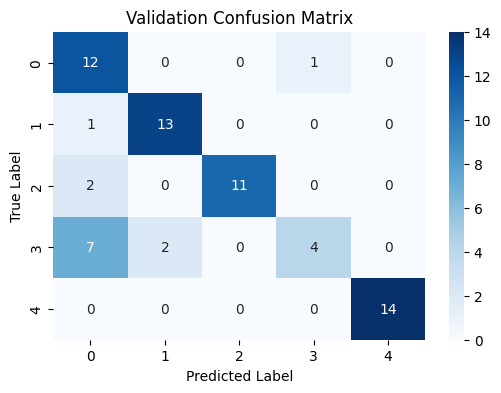


Test Set Results:
Accuracy: 0.76
Cohen's Kappa: 0.71
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.86      0.63        14
           1       0.86      0.92      0.89        13
           2       1.00      0.86      0.92        14
           3       0.60      0.21      0.32        14
           4       1.00      1.00      1.00        13

    accuracy                           0.76        68
   macro avg       0.79      0.77      0.75        68
weighted avg       0.79      0.76      0.75        68



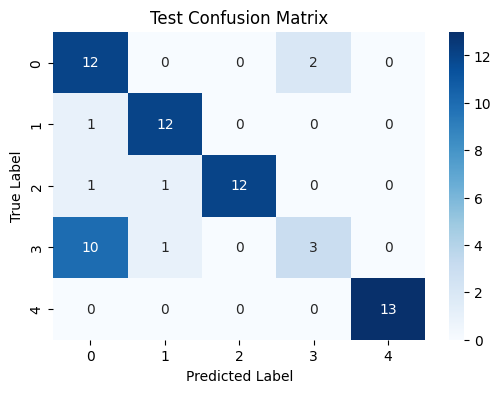

In [14]:
# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Evaluate on validation and test sets
rf_y_val_pred = rf_model.predict(X_val_tfidf)
rf_y_test_pred = rf_model.predict(X_test_tfidf)

# Metrics for validation set
rf_val_accuracy = accuracy_score(y_val, rf_y_val_pred)
rf_val_class_report = classification_report(y_val, rf_y_val_pred, zero_division=0)
rf_val_cohen_kappa = cohen_kappa_score(y_val, rf_y_val_pred)
rf_val_cm = confusion_matrix(y_val, rf_y_val_pred)

# Metrics for test set
rf_test_accuracy = accuracy_score(y_test, rf_y_test_pred)
rf_test_class_report = classification_report(y_test, rf_y_test_pred, zero_division=0)
rf_test_cohen_kappa = cohen_kappa_score(y_test, rf_y_test_pred)
rf_test_cm = confusion_matrix(y_test, rf_y_test_pred)

# Print results
print("Validation Set Results:")
print(f"Accuracy: {rf_val_accuracy:.2f}")
print(f"Cohen's Kappa: {rf_val_cohen_kappa:.2f}")
print("Classification Report:")
print(rf_val_class_report)
plt.figure(figsize=(6,4))
sns.heatmap(rf_val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_val)), yticklabels=sorted(set(y_val)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix")
plt.show()

print("\nTest Set Results:")
print(f"Accuracy: {rf_test_accuracy:.2f}")
print(f"Cohen's Kappa: {rf_test_cohen_kappa:.2f}")
print("Classification Report:")
print(rf_test_class_report)
plt.figure(figsize=(6,4))
sns.heatmap(rf_test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Confusion Matrix")
plt.show()